<a href="https://colab.research.google.com/github/slyofzero/Hunting-Exoplanets/blob/main/Hunting_Exoplanets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aim 

To create a Machine Learning model to predict if a planet is an exoplanet.



---

Train data - https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data?select=exoTrain.csv

Test data - https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data?select=exoTest.csv

The columns `FLUX1 to FLUX3197` consist of brightness measurements of 5087 different stars; while the column `LABEL` denotes whether the planet is an exoplanet (2 -> is an exoplanet, 1 -> is'nt an exoplanet).

In [1]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/C.S/Colab_file_uploads/kaggle.json ~/.kaggle/kaggle.json
!kaggle datasets download -d keplersmachines/kepler-labelled-time-series-data

 88% 49.0M/55.9M [00:01<00:00, 50.1MB/s]
100% 55.9M/55.9M [00:01<00:00, 39.9MB/s]


In [2]:
!unzip /content/kepler-labelled-time-series-data.zip

Archive:  /content/kepler-labelled-time-series-data.zip
  inflating: exoTest.csv             
  inflating: exoTrain.csv            


In [3]:
#Importing the necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_df = pd.read_csv("/content/exoTrain.csv")
test_df = pd.read_csv("/content/exoTest.csv")

In [4]:
#Check and manage all null values in both datasets
print(f"Number of null values in training data = {train_df.isna().sum().sum()}")
print(f"Number of null values in testing data = {test_df.isna().sum().sum()}")

Number of null values in training data = 0
Number of null values in testing data = 0


Before I proceed with the models, let me explain how someone can detect an exoplanet just by looking at the brightness intensities of a star.

Let's look at torches for a second.
If I cover the head of a lit torch with my hand, there would be a huge drop in brightness both visually and by measuring it.

The same way, if a planet comes in front of a star, the brightness measurements from the Keppler telescope would see a huge decrease from its average values.



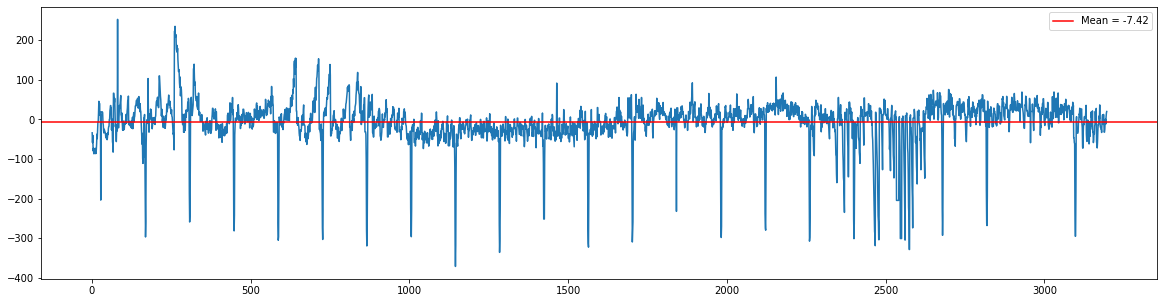

In [5]:
#Plotting a line graph of one of the stars
train_exoplanets_df = train_df.iloc[train_df[train_df["LABEL"] == 2].index, 1:]
star_1 = train_exoplanets_df.iloc[1, 1:]

plt.figure(figsize = (20,5))
plt.plot([i for i in range(1, len(star_1) + 1)] ,star_1)
plt.axhline(star_1.mean(), color = "red", label = f"Mean = {round(star_1.mean(), 2)}")
plt.legend()
plt.show()

As you can see, in this graph the `FLUX` values of a star decrease periodically, signaling that the planet is an exoplanet.

Now let's proceed to the Machine Learning model.

---
First, I'll have to split the datasets in target and feature variables.

The `LABEL` column would be the target variable in both datasets, while the `FLUX1` to `FLUX3197` columns would be the feature variable in both datasets.

In [6]:
#Splitting the data into feature and target variable
X_train = train_df.iloc[:, 1:]
y_train = train_df["LABEL"]

X_test = test_df.iloc[:, 1:]
y_test = test_df["LABEL"]

As I would be classifying data on the basis of FLUX measurements, we would be using Classification models for predictions.

One such Classification models is the `RandomForestClassifier`.

In [7]:
#Importting RandomForestClassifier and fit and predict the data
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_jobs = -1, n_estimators = 50)
rf_clf.fit(X_train, y_train)
y_pred = pd.Series(rf_clf.predict(X_test))
print(f"Accuracy = {round(rf_clf.score(X_train, y_train), 4) * 100}%")

Accuracy = 99.96000000000001%


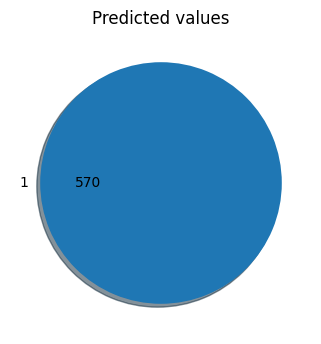

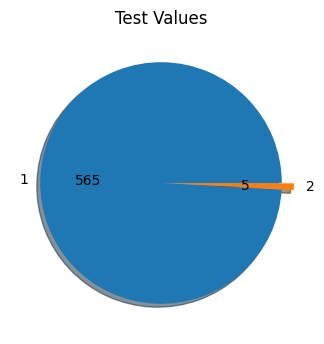


Confusion matrix -> 
[[565   0]
 [  5   0]]

Classification Report -> 
               precision    recall  f1-score   support

           1       0.99      1.00      1.00       565
           2       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



In [8]:
#Importting confusion matrix and classification report and check the true accuracy of the model
plt.figure(dpi = 100)
plt.pie(y_pred.value_counts(), labels = y_pred.value_counts().index, autopct = lambda x:"{:.0f}".format(x * y_pred.value_counts().sum()/100), shadow = True)
plt.title("Predicted values")
plt.show()

plt.figure(dpi = 100)
plt.pie(y_test.value_counts(), labels = y_test.value_counts().index, autopct = lambda x:"{:.0f}".format(x * y_test.value_counts().sum()/100), explode = [0, 0.1], shadow = True)
plt.title("Test Values")
plt.show()

from sklearn.metrics import confusion_matrix, classification_report

print(f"\nConfusion matrix -> \n{confusion_matrix(y_test, y_pred)}\n")
print(f"Classification Report -> \n {classification_report(y_test, y_pred, zero_division = 0)}")

Even though the model shows a 100% accuracy, it hasn't predicted a single exoplanet even though the testing data has 5 of them.

The confusion matrix shows that there are `5 False Positive` values, which means 5 values which are supposed to be 2 are being classed as 1.

The `recall` and `f1-score` for class 2 should be close to `1.0` for the model to be satisfactory but here both are 0.

This means that I'll have to rework on my model.....

---
The first method of reworking that I can try is by working on the data itself.

Normalising the data can help in making it much more uniform which removes any kind of large data from the series and replaces it with a much more moderate number. This helps in removing any kinds of bias, aiding the model's learning process.

In [9]:
#Implementing Mean Normalisation
def mean_normalise(series):
  series = pd.Series(series)
  return (series - series.mean())/(series.max() - series.min())

norm_train_df = X_train.apply(mean_normalise, axis = 1)

norm_test_df = X_test.apply(mean_normalise, axis = 1)

Now let's apply Fast Fourier Transformation onto the dataset.

FFT allows us to convert a time based data to frequency based data, allowing us to see the variation and peaks in data much clearly.

In [10]:
#Applying Fast Fourier Transformation
def fast_fourier_transformation(series):
  series = np.fft.fft(series, len(series))
  return np.abs(series)

X_fft_train = norm_train_df.T.apply(fast_fourier_transformation, axis = 0).T
X_fft_test = norm_test_df.T.apply(fast_fourier_transformation, axis = 0).T

Now I'll use SMOTE to oversample the data. This'll allow the model to have a larger training set than the one it previously had.

In [11]:
#Applying SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 0)
X_fft_train_result, y_fft_train_result = smote.fit_resample(X_fft_train, y_train)
print(X_fft_train_result)
print(y_fft_train_result)

             FLUX.1      FLUX.2     FLUX.3      FLUX.4      FLUX.5  \
0      6.620116e-14    2.273248  35.722883   33.978236  128.816503   
1      4.821195e-14   30.299298  36.918808   38.376852   22.149931   
2      1.291464e-13   66.809870  19.498262  170.268810   48.413391   
3      2.498890e-14   19.369720  52.151962  108.097894  100.659024   
4      6.706859e-14  113.576655  51.382781  146.597215  148.627668   
...             ...         ...        ...         ...         ...   
10095  1.489104e-14    8.563106  47.975903   24.668127   20.798153   
10096  3.497290e-14    5.875786  62.032084   45.646594   34.537945   
10097  2.690570e-14   25.933566  26.108183   27.122940   14.856739   
10098  3.001703e-14   44.692802  40.773934  148.055880   19.383163   
10099  2.896946e-15    2.321980   4.589858    1.110833    3.922128   

           FLUX.6      FLUX.7     FLUX.8     FLUX.9    FLUX.10  ...  \
0       18.835061   16.101795  10.722037  18.488302  16.400976  ...   
1       33.282191

Now let's retry the `RandomForestClassifier`

In [12]:
#Retrying with a better training data
rf_clf = RandomForestClassifier(n_jobs = -1, n_estimators = 50)
rf_clf.fit(X_fft_train_result, y_fft_train_result)
y_pred = pd.Series(rf_clf.predict(X_fft_test))
print(f"Accuracy = {round(rf_clf.score(X_fft_train_result, y_fft_train_result), 4) * 100}%")

Accuracy = 100.0%


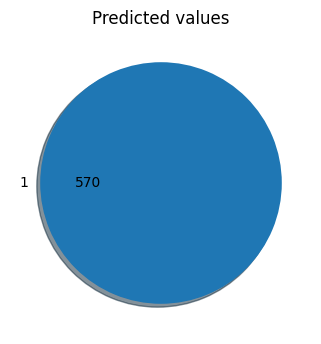

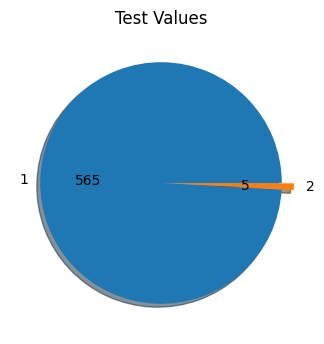


Confusion matrix -> 
[[565   0]
 [  5   0]]

Classification Report -> 
               precision    recall  f1-score   support

           1       0.99      1.00      1.00       565
           2       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



In [13]:
#Check the true accuracy of the model
plt.figure(dpi = 100)
plt.pie(y_pred.value_counts(), labels = y_pred.value_counts().index, autopct = lambda x:"{:.0f}".format(x * y_pred.value_counts().sum()/100), shadow = True)
plt.title("Predicted values")
plt.show()

plt.figure(dpi = 100)
plt.pie(y_test.value_counts(), labels = y_test.value_counts().index, autopct = lambda x:"{:.0f}".format(x * y_test.value_counts().sum()/100), explode = [0, 0.1], shadow = True)
plt.title("Test Values")
plt.show()

print(f"\nConfusion matrix -> \n{confusion_matrix(y_test, y_pred)}\n")
print(f"Classification Report -> \n {classification_report(y_test, y_pred, zero_division = 0)}")

Even after remodelling the data by **normalising** it and by using **Fast Fourier Transformation** and **SMOTE oversampling**, the `RandomTreeClassifier` module wasn't able to predict a single exoplanet.

I'll again have to rework on the model but this time by using the `XGBoost Classifier`

I saved the `XGBoost Classifier` for the last because it is a very resource intensive model and requires a longer time to run.

In [14]:
#Applying XGBoost CLassifier
import xgboost

xgb_clf = xgboost.XGBClassifier()
xgb_clf.fit(X_fft_train_result, y_fft_train_result)
y_pred = pd.Series(xgb_clf.predict(X_fft_test))

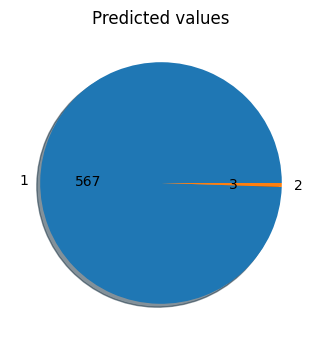

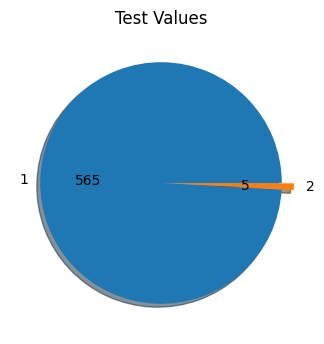


Confusion matrix -> 
[[565   0]
 [  2   3]]

Classification Report -> 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       565
           2       1.00      0.60      0.75         5

    accuracy                           1.00       570
   macro avg       1.00      0.80      0.87       570
weighted avg       1.00      1.00      1.00       570



In [15]:
#Check the true accuracy of the model
plt.figure(dpi = 100)
plt.pie(y_pred.value_counts(), labels = y_pred.value_counts().index, autopct = lambda x:"{:.0f}".format(x * y_pred.value_counts().sum()/100), shadow = True)
plt.title("Predicted values")
plt.show()

plt.figure(dpi = 100)
plt.pie(y_test.value_counts(), labels = y_test.value_counts().index, autopct = lambda x:"{:.0f}".format(x * y_test.value_counts().sum()/100), explode = [0, 0.1], shadow = True)
plt.title("Test Values")
plt.show()

print(f"\nConfusion matrix -> \n{confusion_matrix(y_test, y_pred)}\n")
print(f"Classification Report -> \n {classification_report(y_test, y_pred, zero_division = 0)}")

Finally the model predicted some exoplanets. Even though it was only able to predict 3 out of 5, it is a huge leap from the 0 we got earlier from the `RandomForestClassifier`.

The recall and f1_scores are something much closer to 1.0 now showing that our model has yielded satifactory results.

---
#**END OF THE PROJECT**
---